<div align="center">
<a href="https://vbti.nl"><img src="./images/vbti_logo.png" width="400"></a>
</div>

In [1]:
# load some default libraries
import tensorflow as tf
import numpy as np
import seaborn as sns

%matplotlib inline

%load_ext autoreload
%autoreload 2


def set_gpu(idxs=None):
    """Set visible GPUs
    ids: list of GPU ids to be visible, None to disble all GPUs
    """
    import tensorflow as tf
    gpu_devices = [x for x in tf.config.list_physical_devices() if x.device_type=='GPU']
    
    idxs = idxs or []
    set_visible = [gpu_devices[idx] for idx in idxs]
    
    try:
        # Disable all GPUS
        tf.config.set_visible_devices(set_visible, 'GPU')
        visible_devices = tf.config.get_visible_devices()
        for device in visible_devices:
            assert device.device_type != 'GPU'
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
    finally:
        print(tf.config.get_visible_devices())
        
# set_gpu([0])

# Deep Q-Network <a href="https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf">[paper]</a>

In the previous chapter the Q-learning algorithm in tabular form was extended to problems with continuous states via (state/action) value function approximation.

In some situations, using Multi-Layer Perceptron function approximation is not sufficient. For instance, when using RL to play Atari games, the state consists of screen frames. An Atari screen frame is an image of size 210x160 with RGB pixels. The total number of possible single frames is $(210 * 160 * 3)^{255}$. If we want to process the image input with a Dense layer, the total number of parameters that we need is going to explode quite rapidly. For example if we use 512 units in the first layer the number of parameters will be $210 * 160 * 3 * 512 = 51 609 600$. Such network will be very costly to train. 

Recently, convolutional neural networks have been shown to be very effective in processing images. A CNN is, just like any other neural network, a non-linear function approximator. However, it reuses its weights on different parts of the image. By combining CNN's and Q-learning you will receive a famous algorithm called **Deep Q-Network**, that was originaly used to solve some of the Atari games.

<img src="images/dqn_alg.png" width=600 />
<center> DQN algorithm from original <a href="https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf">[paper]</a></center>

As you can see wee need to implement couple of things.
1. Neural Network
2. Epsilon Greedy agent that will use the Network for exploitation phase
3. Experience Replay for training the network
4. Input Preprocessing (which is not part of the algorithm but it is very important)

First we will define how to pre-process frames from the gym environment. Then we will define the neural network architecture and its training procedure. Then we implement Experience Replay and then we move to the functionality of the agent. Full implementation is located in ```QLearning.dqn``` python package. Here we present only the snippets of code alongside with the explanation.

## Frame Preprocessing
The DQN will use an Atari screen frame as an observation. However, a single frame does not contain the information about direction or velocity of the objects. To maintain Markov Property we will stack several frames alongside the channel dimension. Such stack of frames would contain all the information, so that a CNN should be able to derive the velocities and directions of the objects.

To make the learning more efficient, we remove 'unused' information from the stacked frames. First we resize images to $84 \times 84$ and remove color information. Additionally, we will let the network make a decision only every 4'th frame, while max-pooling the last two frames together (due to flikerings in some of the environments). In this way, the receive a robust observation that is suitable for most of the Atari games.

In [2]:
from QLearning.env_wrappers import AtariPreprocessing, AtariFrameStack
import matplotlib.pyplot as plt

import gym


env = gym.make('PongNoFrameskip-v0')
print('Original observation shape:', env.observation_space)
env_preprocessed = AtariPreprocessing(env, frame_skip=4)
print('Preprocessed observation shape:', env_preprocessed.observation_space)
env_stacked = AtariFrameStack(env, frame_skip=4)
print('Stacked observation shape:', env_stacked.observation_space)

Original observation shape: Box(0, 255, (210, 160, 3), uint8)
Preprocessed observation shape: Box(0, 255, (84, 84, 1), uint8)
Stacked observation shape: Box(0, 255, (84, 84, 4), uint8)


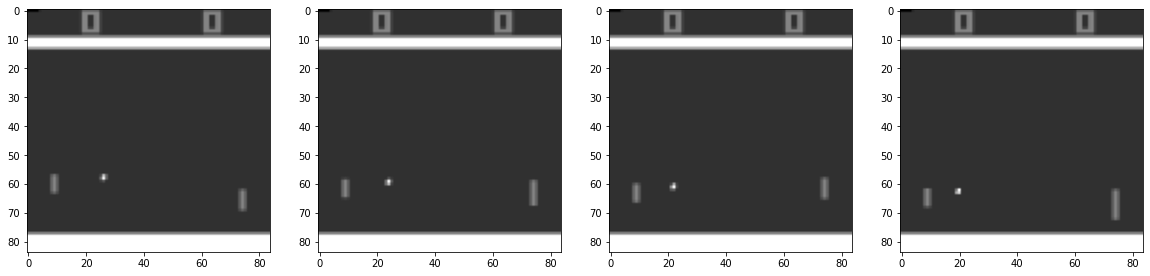

In [3]:
def plot_stack(frame_stack):
    num_frames = frame_stack.shape[-1]
    fig, ax = plt.subplots(1, num_frames, figsize=(20, 20), )
    for i in range(num_frames):
        ax.flat[i].imshow(frame_stack[..., i], cmap='gray')
        ax.flat[i].grid(False)
    plt.show()
    

state = env_stacked.reset()
for i in range(20):
    state, _, _, _ = env_stacked.step(env.action_space.sample())
plot_stack(state)

The plot above shows the resulting observation. The leftmost is the oldest frame in the stack and it is going to be removed as soon as the new observation is obtained (therefore we can derive that the ball is moving to the left).

## Network architecture
Convolutional Neural Networks are very suitable for processing high dimensional image data. For this task a simple feed forward architecture with three convolutional layers will do the job. You can think about CNN as a **feature extractor** - high-dimensional images will be projected to an abstract low-dimensional space.

<div align="center">
<img src="./images/DQN_Atari.png" width="800">
</div>

Also, instead of estimating $\hat{Q}(s,a|\textbf{w})$ the CNN outputs a q-value for every action, that is $\hat{Q}_{action_i}(s|\textbf{w})$. Hence, the CNN is a multi-output CNN. While fundamentally nothing changes, it is a more efficient way of implementing the algorithm.

**Note:** The actual code is a bit different to support different CNN configurations. The example below can be obtained by setting the following parameters. 

```python
mlp_act_f="relu",
cnn_number_of_maps=(16, 32, 32)
cnn_kernel_size=(8, 4, 3)
cnn_kernel_stride=(4, 2, 1)
mlp_value_n_hidden=(256, 512,)
mlp_value_act_f="tanh",

```


```python

def create_model(self, model_name):
    input_state = tf.keras.Input(shape=self.state_shape,
                                 batch_size=None,
                                 name='state_input',
                                 dtype=tf.uint8)

    x = tf.divide(tf.cast(input_state, dtype=tf.float32), tf.constant(255., dtype=tf.float32))

    x = Conv2D(16, kernel_size=(8, 8), strides=(4, 4),
               padding='valid', activation='relu', name='conv1')(x)
    x = Conv2D(32, kernel_size=(4, 4), strides=(2, 2),
               padding='valid', activation='relu', name='conv2')(x)
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
               padding='valid', activation='relu', name='conv3')(x)

    x = Flatten()(x)
    
    x = Dense(256, activation='tanh', name='hidden')(x)

    x = Dense(512, activation='tanh', name='hidden_dense_value')(x)

    q_values = Dense(self.n_actions, activation='linear', name='value_output')(x)

    q_network = Model(inputs=[input_state], outputs=[q_values], name=model_name)
    return q_network

```

We will assign this model to our DeepQNetwork class as a property.
```python
class DeepQNetwork:
    def __init__(self, obs_shape, n_actions, learning_rate=1e-4, gamma=0.99):
        self.n_actions = n_actions
        self.obs_shape = obs_shape

        self.online_network = self.create_model('dqn')

```
We can now define a couple of methods that would allow us to train and query the network.
    
Exploit the best option $argmax_a Q(s, a; \theta)$
```python
@tf.function
def get_best_action(self, obs):
    return tf.argmax(self.online_network(obs), axis=1)
```
Get maximum q-values from given state $max_a Q(s, a; \theta)$
```python
@tf.function
def get_best_action_value(self, obs):
    return tf.reduce_max(self.online_network(state), axis=1)
```

For the network to be properly defined, we need to specify how the network is going to be trained. For training the network we are going to defined one training operation, i.e. gradient descent for one batch of transition data sampled from replay buffer. Steps in this method:
- Calculate the target
$$y=r+\gamma \max_{a'}Q(s',a';\theta)$$
- Calculate the loss
$$L(\theta) = \mathbb{E}[(y - Q(s,a;\theta)^2)]$$
- Perform gradient descent
$$\nabla_{\theta}L(\theta) = \mathbb{E}\left[(r + y - Q(s, a; \theta))\nabla_{\theta}Q(s, a;\theta)\right]$$

```python
@tf.function
def train_op(
    self, replay_obs, replay_action, replay_rewards, replay_next_obs, terminal
):
    # We assume that if have received a uint8 this means we need to normalize
    if replay_obs.dtype == "uint8":
        replay_obs = tf.cast(replay_obs, tf.float32) / 255.0
        replay_next_obs = tf.cast(replay_next_obs, tf.float32) / 255.0

    replay_continues = 1.0 - terminal
    # get max q-values for the next state
    q_best_next = self.get_best_action_value(replay_next_obs)
    # calculate target, if episode is over do not add next q-values to the target
    y_val = replay_rewards + replay_continues * self.gamma * q_best_next
    with tf.GradientTape() as tape:
        # calculate current q-values
        q_values = self.online_network(replay_obs)
        # get the q-values of the executed actions
        q_values_masked = tf.reduce_sum(
            q_values * tf.one_hot(replay_action, self.n_actions),
            axis=1,
            keepdims=False,
        )
        # calculate loss
        loss = self.loss_layer(q_values_masked, y_val)
    # compute gradients
    gradients = tape.gradient(loss, self.online_network.trainable_variables)
    # apply gradients
    self.optimizer.apply_gradients(
        zip(gradients, self.online_network.trainable_variables)
    )
    return loss
```

## Replay Memory

We might be tempted to perform gradient update every time we have a new batch of observations ready. However, the several consequent observations are dependent on each other. This correlation breaks the qualification for stochastic gradient descent, since one of the assumption is that the batch data is i.i.d. sample from a certain distribution. In order to break this correlation we are going to use Experience Replay. First we collect the experiences in a buffer, then we sample a batch from it and perform a gradient update. We also include 3 of the most recent observations in the sample to make sure that the training is performed on each of the observations at least once. It is very convenient and fast to use a ```collections.deque``` for this. This standard Python data-structure can maintain fixed length by removing the oldest elements when the capacity is reached.

```python
from collections import deque

class ReplayBuffer:
    def __init__(self, replay_capacity=50000, include_last_samples=3):
        self.include_last = include_last_samples
        self._buffer = deque(maxlen=replay_capacity)

    def store(self, transition):
        self._buffer.appendleft(transition)

    def sample_batch(self, batch_size):
        batch = random.sample(self._buffer, batch_size)
        for i in range(self.include_last):
            batch[i] = self._buffer[i]
        return self._batch_to_arrays(batch)
```

## Agent and Exploration
First we define an interface for an agent. ```compute_action``` would return the next action given state. ```update``` is used for agent training. And if we were recording any statistic during the episode we would return it in ```finalize_episode```.

```python
class Agent:
    """
    Interface for the agent class
    """

    def compute_action(self, state):
        ...

    def update(self, *args, **kwargs):
        ...

    def finalize_episode(self, *args, **kwargs):
        ...
```
We can easily extend this class to implement RandomAgent.

```python
class RandomAgent(Agent):

def __init__(self, n_actions):
    self.n_actions = n_actions

def compute_action(self, state):
    return random.randrange(self.n_actions)
```

In order to bind everything together we are going to assign a network and replay buffer to the ```EpsilonGreedyAgent``` class. Lets have a look at its main methods.

```python
class EpsilonGreedyAgent:
    def __init__(self, n_actions, network):
        super().__init__(n_actions)
        self.network = network
        self.replay_buffer = ReplayBuffer(replay_capacity)
```

Now we defined function for computing next state. For this we use our current epsilon value, where 1.0 means only exploration and 0.0 is only exploitation.
```python
    def compute_action(self, state):

        if np.random.rand() < self.epsilon:
            return super().compute_action(state)
        else:
            action = self.network.get_best_action(state)
            return action
```
We are going to anneal the epsilon value from 1.0 to 0.02 with this formula.
$$\epsilon = \epsilon_{min} + (\epsilon_{max} - \epsilon_{min}) * exp(-\epsilon_{decay} * t)$$, where $t$ is the current timestep. In most of the papers the training lasts until 200 million frames. Pong, however is a bit easier game, so we don't need to explore for too long. We are going to train for approx. 5 million frames, therefore $\epsilon_{decay}$ should be $10^{-6}$ to make sure that the agent explores actively for at least half of that time. We can see the exploration value on the plot bellow.

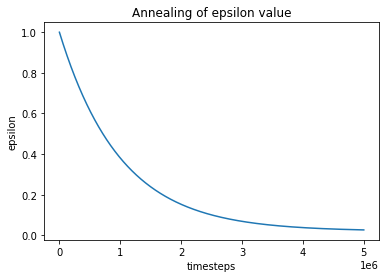

In [4]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def update_epsilon(time_step, min_epsilon, max_epsilon, epsilon_decay):

    epsilon = min_epsilon + \
                   (max_epsilon - min_epsilon) \
                   * math.exp(-epsilon_decay * time_step)
    return epsilon

# These values will nicely decrease epsilon value to 0.02 within a million timesteps.
# For games harder even smaller epsilon decay values are used.
start_epsilon = 1.0
end_epsilon = 0.02
epsilon_decay = 1e-6

total_timesteps = 5e6

timesteps = np.linspace(0, 5e6, 1000)
epsilon_values = [update_epsilon(t, end_epsilon, start_epsilon, epsilon_decay) for t in timesteps]
ax = sns.lineplot(x=timesteps, y=epsilon_values)
ax.set(xlabel='timesteps', ylabel='epsilon')
plt.title('Annealing of epsilon value')
plt.show()

## Training

In [3]:
import gym
from QLearning.env_wrappers import AtariFrameStack
from QLearning.dqn import DeepQNetwork, EpsilonGreedyAgent
from os.path import join

EXPERIMENT_FOLDER = 'Experiments/pong_dqn_01'
video_folder = join(EXPERIMENT_FOLDER, 'video')
save_interval = 100

env = AtariFrameStack(gym.make('PongNoFrameskip-v4'),
                      frame_skip=4,
                      terminal_on_life_loss=False,
                      screen_size=84,
                      stack_size=4,
                      skip_init=20)
from gym.wrappers import monitor
env = gym.wrappers.Monitor(env, video_folder, force=True,
                          video_callable=lambda episode_id: episode_id % save_interval == 0)
        
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

q_network = DeepQNetwork(
    state_shape=env.observation_space.shape,
    n_actions=env.action_space.n,
    learning_rate=6.25e-5,
    gamma=0.99,
    cnn_number_of_maps=(16, 32, 32),
    cnn_kernel_size=(8, 4, 3),
    cnn_kernel_stride=(4, 2, 1),
    mlp_value_n_hidden=(256, 512,),
    mlp_value_act_f="tanh",
)

agent = EpsilonGreedyAgent(
    n_actions=env.action_space.n,
    network=q_network,
    replay_capacity=10000,
    gamma=0.99,  # discount of future rewards
    training_start=5000,  # start training after x number of steps
    training_interval=4,  # train every x steps
    batch_size=32,
    start_epsilon=1.0,
    end_epsilon=0.02,
    epsilon_decay=1e-6,
    root_folder=EXPERIMENT_FOLDER,
    save_best=True,
    save_interval=save_interval
)

# Define history object to hold all statistics. Usefull if you want to continue training
history = {}

Observation space: Box(0, 255, (84, 84, 4), uint8)
Action space: Discrete(6)


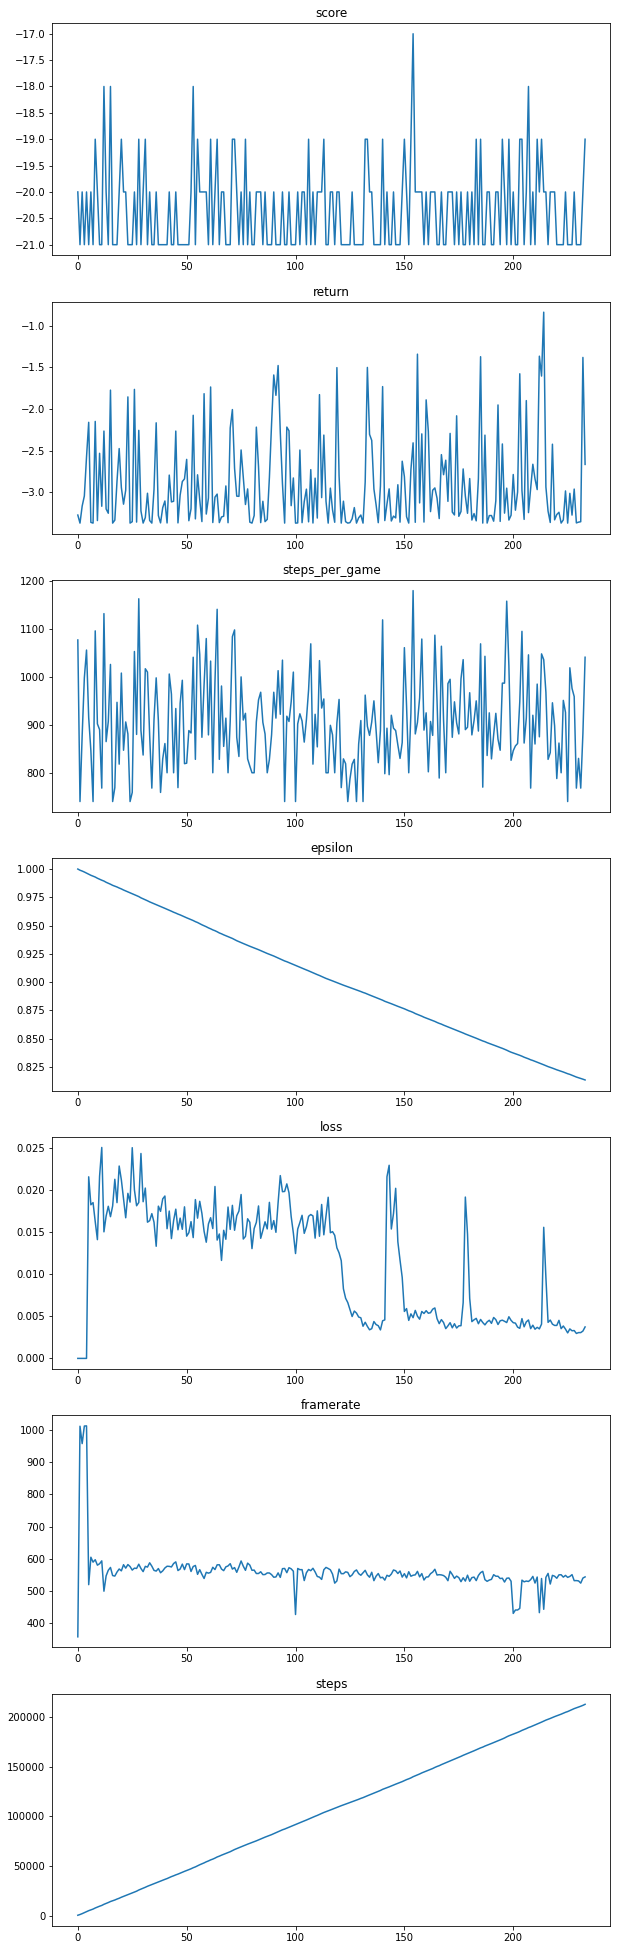

In [ ]:
# Cell to train the agent. If you want to load the weights, skip this cell.
from QLearning.dqn import run_experiment

run_experiment(env, agent, runs=2500, history=history,
               plot_stats=[
                   'score',
                   'return',
                   'steps_per_game',
                   'epsilon',
                   'loss',
                   'framerate',
                   'steps'
               ], plot_period=1
              )

env.close()

In [8]:
# Save the model and dump the history file
agent.save_model(join(EXPERIMENT_FOLDER, 'latest'))

# Save history file
from dqn import save_history
save_history(history, join(EXPERIMENT_FOLDER, 'history.json'))

INFO:tensorflow:Assets written to: pong_dqn/latest/assets


## Pre-trained agent
### Checking history
Since training can take up to 8 hours on average GPUs, we have pre-trained a Pong agents that you can load and experiment with. You can check the history of the training process by loading up the history with the following code.

dict_keys(['score', 'steps_per_game', 'framerate', 'runs', 'return', 'epsilon', 'loss', 'steps'])


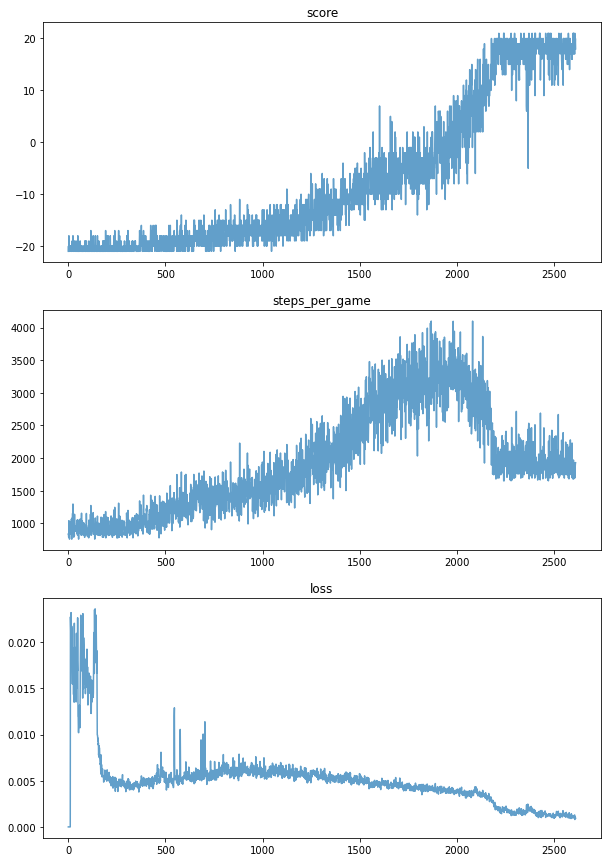

In [15]:
from QLearning.dqn import load_history, plot_history
from os.path import join

EXPERIMENT_FOLDER = join('Experiments', 'pong_dqn')
history = load_history(join(EXPERIMENT_FOLDER, 'history.json'))
print(history.keys())
plot_history(history, ['score', 'steps_per_game', 'loss'])

### To load the agent and play the game

- Set the experiment folder to the ```EXPERIMENT_FOLDER``` variable
- Create the environment
- Create a instance of a network.
- Load the weights with ```q_network.load(path)```
- Create an agent ```EpsilonGreedyAgent(network=q_network)```
- Remember to set ``````EpsilonGreedyAgent(start_epsilon=0.02)`````` to a small value, to ensure exploration.

In [14]:
from os.path import join

import gym

from QLearning.dqn import EpsilonGreedyAgent, DeepQNetwork
from QLearning.env_wrappers import AtariFrameStack

EXPERIMENT_FOLDER = 'Experiments/pong_dqn'

env = AtariFrameStack(gym.make('PongNoFrameskip-v4'))
q_network = DeepQNetwork(state_shape=env.observation_space.shape,
                         n_actions=env.action_space.n)
# Load the network
q_network.load(join(EXPERIMENT_FOLDER, 'latest'))

agent = EpsilonGreedyAgent(n_actions=env.action_space.n, network=q_network, start_epsilon=0.02)

OSError: SavedModel file does not exist at: Experiments/pong_dqn/latest/{saved_model.pbtxt|saved_model.pb}

### Let the agent play and record the video

In [4]:
from dqn import run_episode

video_path = join(EXPERIMENT_FOLDER, 'videos')
                  
env = gym.wrappers.Monitor(env, video_path, force=True)
print(run_episode(env, agent, train=False))
env.close()

{'score': 19.0, 'steps_per_game': 1857, 'framerate': 263.61016122653547, 'runs': 0, 'return': 0, 'epsilon': 0.02, 'loss': 0, 'steps': 0}


In [34]:
from IPython.display import Video
import os

# take the last element in the folder with .mp4 extension
video_name = [x for x in os.listdir(video_path) if '.mp4' in x][-1]
Video(join(video_path, video_name), embed=True)

### Training progress
Here is couple of videos that were captured during the training process.

#### 1000 episodes, Reward: -12

In [35]:
from IPython.display import Video
Video(join("Experiments", "atari_recordings", "dqn_pong_-12.mp4"), embed=True)

### 2000 episodes, Reward: -3

In [37]:
from IPython.display import Video
Video(join("Experiments", "atari_recordings", "pong_dqn_-3.mp4"), embed=True)

### 2500 episodes, Reward: 18

In [38]:
Video(join("Experiments", "atari_recordings", "dqn_pong_18.mp4"), embed=True)


# References

[1] Richard Sutton & Andrew Barto, Reinforcement Learning – An Introduction, november 2018
